# Create Distance Infographic - Cosmic Explorer Trade Study 

This Notebook reads from the output of Bayesian inference runs and creates a distance infographic for measuring the parameters of a CBC signal to within 10% accuracy.

### Import modules


In [1]:
import numpy
import matplotlib.pyplot as plt
from matplotlib import rcParams
import json
from matplotlib.patches import Patch
import seaborn as sns
from glob import glob
import collections
import math
import matplotlib.patches as mpatches
import matplotlib.font_manager

# plt.style.use('dark_background')
%matplotlib inline

In [2]:
from matplotlib import rcParams

plt.rc('text', usetex=True)
rcParams["font.family"] = "serif"
rcParams["font.serif"] = "stix"
plt.rcParams["mathtext.fontset"] = "stix"

### color choices

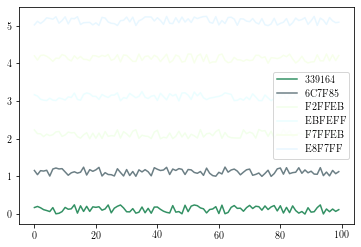

In [3]:
c_palette_list=['#339164','#6C7F85','#F2FFEB','#EBFEFF','#F7FFEB','#E8F7FF']
x = numpy.array(range(100)) 
for ii in range(len(c_palette_list)):
    plt.plot(x, ii + numpy.random.rand(100)*0.25, 
             color=c_palette_list[ii], label=c_palette_list[ii][1:])
plt.legend()

# Fill color settings
color_list = ['#F2FFEB','#EBFEFF','#F7FFEB','#E8F7FF']
alpha = [1,1,1,1,1]

color_dict = {'A$^\sharp$ (HLA)':c_palette_list[1],
              'CE40+2A$^\sharp$':c_palette_list[0],
              'CE40+CE20+A$^\sharp$':'#6ecc7c',
             }

fc = '#5F646F' #color of facility lifetime bar

In [4]:
label_dict = {"BNS-z-2": r"Detect 100 BNS mergers for z $>$ 2 with  $\Delta{\Omega} <100$",
              "BNS-z-5": r"Detect 100 BNS mergers for z $>$ 5",
              "BBH-z-2": r"Detect 30000 BBH mergers for z $>$ 2 with  $\Delta{\Omega} <100$",
              "BBH-z-5": r"Detect 10000 BBH mergers for z $>$ 5",
              
              "NS-radius": r"Constrain Nuclear Equation of State (NS radius $<$ 10 m)",
              "BNS-high-SNR": r"Detect 500 BNS mergers with SNR $>$ 100",
              "sky-loc": r"Locate $100$ BNS mergers within $1 \mathrm{deg}^2$ ",
              "GRB-id": r"Mapping 500 GRBs to progenitors ( $z > 2$ ; $\Delta{\Omega} < 100 \mathrm{deg}^2$)",
              "early-detection": r"Detect $100$ BNS mergers 5 mins before merger",
              
              "postmerger": r"Detect source with postmerger SNR $>$ 5",
              "continuous-waves": r"Detect 50 millisecond pulsars",
              'BBH-snr': r"Detect 10 BBH mergers with SNR $>$ 1000",
              "H0": r"Measure $H_0$ to within $1\%$",
              "BH-postinspiral": r"1000 BBH with post-inspiral SNR $>$ 100",
              "stocastic": r"Measure Stocastic Background"
              
              
#               "Omega": r"Measure $\sigma_{\Omega_m} <0.05$",
#               "GR": r"Precision measurement of GR",
#               "BH-mass-spectrum": r"Measure BH mass spectrum",
#               "NS-mass-spectrum": r"Measure NS mass spectrum",
             }

#inf=500 for now

input_data = [
#-------# SECTION 1 : BHs and NSs Throughout Cosmic Time #-------
    #  https://www.overleaf.com/project/645839ccec69020003928e71
#{"Name": "BNS-z-2", "Section": 1, "A$^\sharp$ (HLA)": 500, "CE40+2A$^\sharp$": 2.7}, #scroll down #bns  hla:0 ce40: 37
    
{"Name": "BNS-z-5", "Section": 1, "A$^\sharp$ (HLA)": 500,
                                  "CE40+2A$^\sharp$": 100 / 82,
                                  "CE40+CE20+A$^\sharp$":100 / 570}, #done table 2 CE_MPSAC_BBH_BNS_NSBH Table 14 hla:0 ce40:8 
    
    
# {"Name": "BBH-z-2", "Section": 1, "A# (HLA)": 17, "CE40+2A#": 2}, #scroll down  #done hla:1767 ce40:15238 table 8
    
{"Name": "BBH-z-5", "Section": 1, "A$^\sharp$ (HLA)": int(10000 / 19), 
                                  "CE40+2A$^\sharp$": 10000 / 3916, 
                                  "CE40+CE20+A$^\sharp$":10000 / 4506}, #done table 2 hla:19 ce40:3916
    
#-------# SECTION 2 : MMA and Dynamics of Dense Matter #-------#
    
# Table 15 of https://www.overleaf.com/project/645839ccec69020003928e71    
{"Name": "sky-loc", "Section": 2, "A$^\sharp$ (HLA)": 100 / 5,
                                  "CE40+CE20+A$^\sharp$": 100 / 97,
                                  "CE40+2A$^\sharp$": 100 / 18},  #table 14 hla:1 ce40:892  
    
{"Name": "NS-radius", "Section": 2, "A$^\sharp$ (HLA)": 50,
                                    "CE40+CE20+A$^\sharp$":3,
                                    "CE40+2A$^\sharp$": 5,}, #done medium eos  

#{"Name": "BNS-high-SNR", "Section": 2, "A$^\sharp$ (HLA)": 833, "CE40+2A$^\sharp$": 2.3}, #done table 2 #chai calculating hla:0.6 ce40:220

    
{"Name": "GRB-id", "Section": 2, "A$^\sharp$ (HLA)": 500,
                                  "CE40+CE20+A$^\sharp$": 500 / 3729,
                                 "CE40+2A$^\sharp$": 500 / 37}, ## of NS-NS at z > 2 with ∆Ω ≤ 100 deg2 #hla:0 =inf ce40:37

# Fig 4 of https://iopscience.iop.org/article/10.3847/2041-8213/ac1a75/pdf (CE40+2A# network), and
# Fig 4 of https://iopscience.iop.org/article/10.3847/2041-8213/abbc10/pdf (A# network), 
{"Name": "early-detection", "Section": 2, "A$^\sharp$ (HLA)": 23, "CE40+2A$^\sharp$": 1}, #done hla: ce40:

#-------# SECTION 3 : New Probes of Extreme Astrophysics #-------#
{"Name": "postmerger", "Section": 3, "A$^\sharp$ (HLA)": 37,
                                     "CE40+CE20+A$^\sharp$": 1.6,
                                     "CE40+2A$^\sharp$": 4.4}, #done need to talk with alex
    
{"Name": "continuous-waves", "Section": 3, "A$^\sharp$ (HLA)": 21, "CE40+2A$^\sharp$": 4,  "CE40+CE20+A$^\sharp$":3}, #talk with alex
    
#-------# SECTION 4: Fundamental Physics and Precision Cosmology #-------#

#{"Name": "BH-postinspiral", "Section": 4, "A$^\sharp$ (HLA)": 167, "CE40+2A$^\sharp$": 1},   #done hla:6 ce40:1190 
    
{"Name": "H0", "Section": 4, "A$^\sharp$ (HLA)": 8, "CE40+2A$^\sharp$": 1}, #done
     
    
{"Name": "BBH-snr", "Section": 4, "A$^\sharp$ (HLA)": 500,
                                  "CE40+2A$^\sharp$": 10 / 3.0, 
                                  "CE40+CE20+A$^\sharp$": 10 / 4.0}, #done    

#-------# SECTION 5:Dark Matter in the Early Universe #-------#

# {"Name": "stocastic", "Section": 5, "A# (HLA)": 200, "CE40+2A#": 2}, #talk with alex


]
section_title = ['BHs and NSs \nThroughout \nCosmic Time', 
                 'MMA and \nDynamics of \nDense Matter', 
                 'New Probes \nof Extreme \nAstrophysics', 
                 'Fundamental \nPhysics and \nPrecision \nCosmology']

In [5]:
hscale = 3.0
shift = 3.2
def plot_dist_bar(network_dict, nw_number, counter, lower_lim):
    '''
    Evaluates the x-ranges for the broken bar for
    each parameter from the dictionary values. Plots 
    the broken bars for each parameter.
    
    Parameters
    ----------
    network_dict: dictionary
        Dictionary with the disctance values
    
    nw_number: int
        Number id for the detctor network
    '''
    section_number = network_dict["Section"] - 1
    sorted_dict = {x: network_dict[x] for x in network_dict if x not in ["Name", "Section"]}
    sorted_dict = collections.OrderedDict(sorted(sorted_dict.items(), key=lambda x: x[1], reverse=True))

    for key in sorted_dict.keys():
        if sorted_dict[key]!= 0:
            if key == "A$^\sharp$ (HLA)":
                p = ax[section_number, 1].barh(hscale*counter + shift, sorted_dict[key]-lower_lim, 
                                               left=lower_lim, height = hscale / 2.3, 
                        color=color_dict[key], alpha = 0.7)
            else:
                p = ax[section_number, 1].barh(hscale*counter + shift, sorted_dict[key]-lower_lim, 
                                               left=lower_lim, height = hscale / 2.3, 
                        color=color_dict[key], alpha = 1)
#             p = ax[section_number, 1].barh(10*counter, sorted_dict[key]-lower_lim, left=lower_lim, height = 5, 
#                         color=color_dict[key], alpha = 1)
            if sorted_dict[key] > 30:
                if sorted_dict[key] == 500:
                    ax[section_number, 1].text(29.8, (hscale*(counter))-1 + 0.5 + shift, "Unachievable",color='white',
                                               horizontalalignment='right', fontsize=9)
                else:
                    ax[section_number, 1].text(29.8, (hscale*(counter))-1 + 0.5 + shift, 
                                            str(str(numpy.round(sorted_dict[key], -1))+' years'),
                                               color='white', horizontalalignment='right', fontsize=9)
                
            ax[section_number, 1].text(0.55+lower_lim, hscale / 2.5 +(hscale*(counter)) + shift - 0.15, 
                                       label_dict[name], fontsize=8)

### Plotting the timelines

plotting times for BBH-z-5
plotting times for BNS-z-5
plotting times for early-detection
plotting times for GRB-id
plotting times for NS-radius
plotting times for sky-loc
plotting times for continuous-waves
plotting times for postmerger
plotting times for BBH-snr
plotting times for H0


<ipython-input-6-62167d400b4f>:82: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


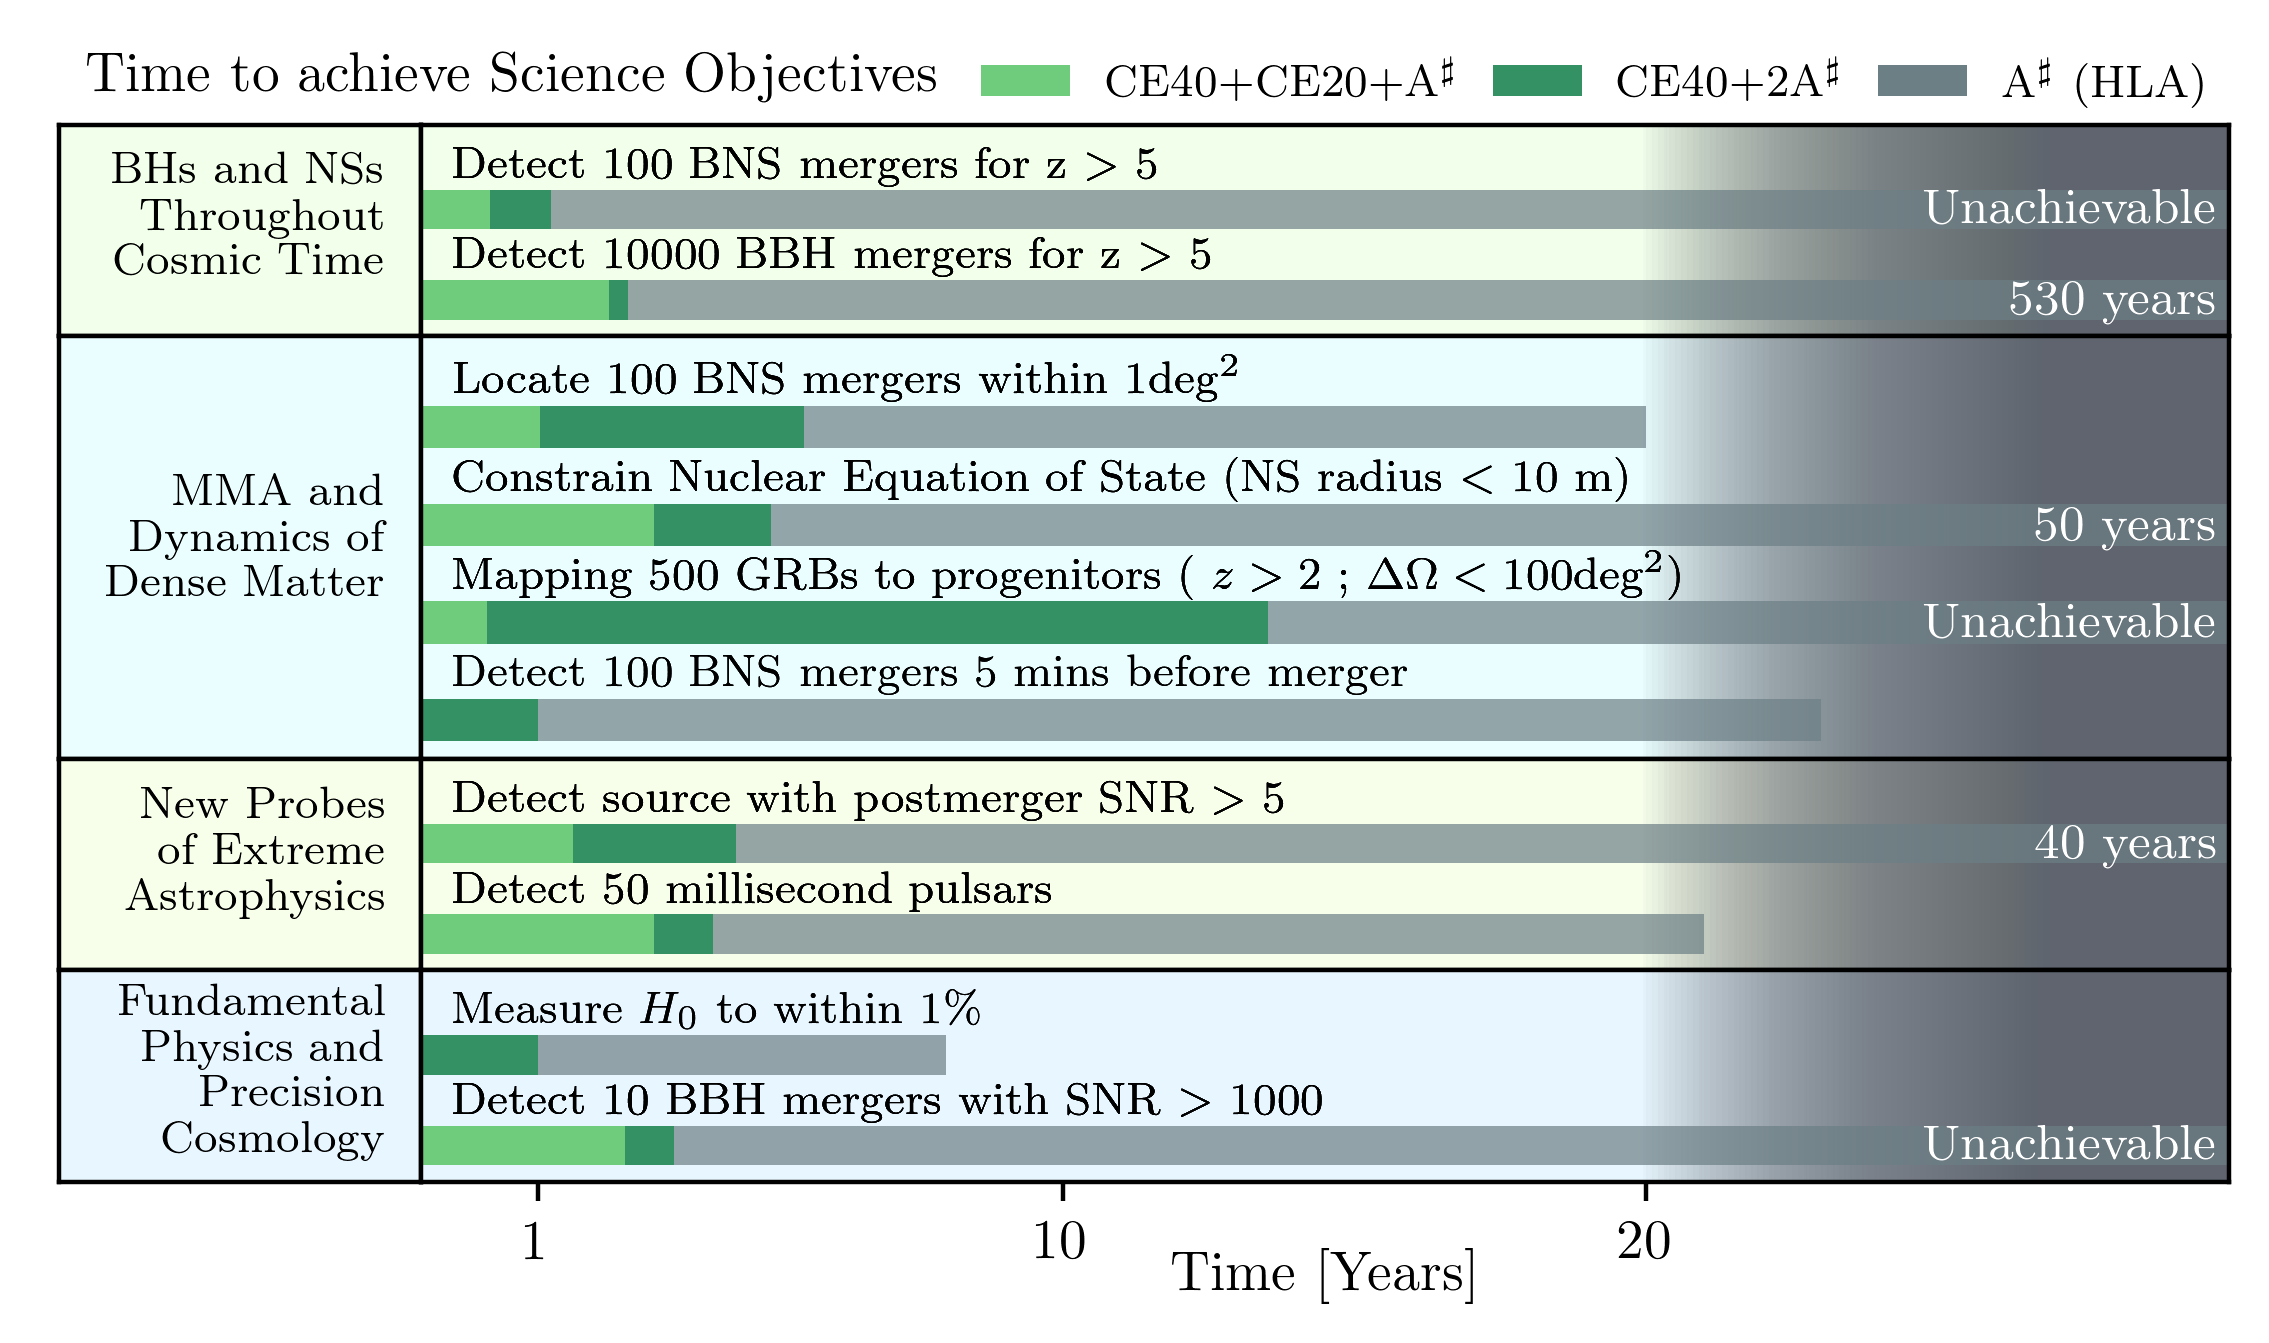

In [6]:
# initiate a list of names for the detector networks
# name_list = []
n_sections = 4
upper_lim = 30
lower_lim = -1
fig, ax = plt.subplots(n_sections, 2, figsize=(7, 3.5), dpi=400, sharex=True, 
                       gridspec_kw={'height_ratios': [2, 4, 2, 2], 'width_ratios': [1, 5]})

# Facility time vertical line
facility_lim = 20

# plt.axvline(facility_lim, linestyle="-.", c=fc)

# plt.fill_between(numpy.linspace(facility_lim, upper_lim, 100),
#                  numpy.ones(100)*150,
#                  color=fc,hatch="///", fc="none")


for jj in range(n_sections):
    ax[jj, 1].fill_between(numpy.linspace(lower_lim,30,100),
                        numpy.ones(100)*0,numpy.ones(100)*150,
                        color=color_list[jj],alpha=alpha[jj],zorder=0)
    
    ax[jj, 0].fill_between(numpy.linspace(lower_lim,30,100),
                        numpy.ones(100)*0,numpy.ones(100)*150,
                        color=color_list[jj],alpha=alpha[jj],zorder=0)

    steps = numpy.arange(facility_lim, upper_lim, .1)
    for step in steps:
        ax[jj, 1].fill_between(numpy.linspace(step, upper_lim, 100),
                         numpy.ones(100)*150,
                         color=fc, fc=fc, alpha=0.03, rasterized=True)



    #ax[jj, 1].axvline(facility_lim, linestyle="-.", c=fc)
    
    counter = 0
    for ii in range(len(input_data)):
        nw_dict = input_data[-ii-1]
        name = nw_dict['Name']
        if nw_dict["Section"] -1 == jj:
            print('plotting times for {}'.format(name))
            plot_dist_bar(nw_dict, ii+1, counter+1, lower_lim)
            counter += 1
    ax[jj, 1].set_ylim(5, 6+(hscale*(counter)))
    ax[jj, 0].set_ylim(5, 6+(hscale*(counter)))
    ax[jj, 1].set_yticks([])
    ax[jj, 0].set_yticks([])
    ax[jj, 1].set_xlim(0, 0.1)
    
gap = -0.6
ax[0, 1].text(gap+lower_lim, 7, section_title[0], rotation=0, horizontalalignment='right', fontsize=8)
ax[1, 1].text(gap+lower_lim, 10, section_title[1], rotation=0, horizontalalignment='right', fontsize=8)
ax[2, 1].text(gap+lower_lim, 7, section_title[2], rotation=0, horizontalalignment='right', fontsize=8)
ax[3, 1].text(gap+lower_lim, 6, section_title[3], rotation=0, horizontalalignment='right', fontsize=8)

# plt.ylim(5, len(input_data)*10+10)

plt.xlabel('Time [Years]', labelpad=-4)
plt.xlim(lower_lim, upper_lim)

ax[-1, 1].set_xticks([1, 10, 20])

legend_elements = [Patch(facecolor=color_dict[key], 
                         label=key) for key in reversed(color_dict.keys())]

# Include in the legend
# facility_limit_patch = mpatches.Patch(facecolor='none', edgecolor=fc, 
#                                       hatch='///', label='Facility lifetime limit')
# legend_elements.append(facility_limit_patch)


# print(legend_elements)
# ax.legend(handles=legend_elements, loc='lower center', fontsize=8)
ax[n_sections-1, 1].legend(handles=legend_elements, loc=(0.3, 5.0), fontsize=8, ncol=3,
                           frameon=False, columnspacing=0.8)

#ax[n_sections-1, 1].text(25.3, 7, "Existing \nFacility\nLifetime", c='w', fontsize=12, weight='bold')
#plt.grid(which='major', axis='x', linestyle='-.', linewidth=1, alpha=0.5)
ax[0,1].set_title('Time to achieve Science Objectives', x=0.05, fontsize=10)
plt.tight_layout()
plt.subplots_adjust(wspace=0.0,hspace=0.0)
ax[3,0].get_xaxis().set_visible(False)
ax[2, 1].set_xticks([1, 10, 20])
plt.savefig('time-to-deliver-science.pdf', bbox_inches='tight', pad_inches=0)
plt.show()